In [75]:
import sys
sys.path.append("../")

import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy import stats
import engarde.decorators as ed

import statsmodels.formula.api as smf
from linearmodels import PanelOLS
#from library import test

from matplotlib import lines, markers
from cycler import cycler

pd.set_option('mode.chained_assignment', None)

In [76]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
data = data[data.doi == True]
data.sample()

,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,middle_math,middle_reading,middle_science,algebra,biology,eng1,math,reading,avescores,treatpost
168310,168310,57905360,2019,m_7th_avescore,1673.0,0.558767,D A HULCY STEAM MIDDLE,N,57905,DALLAS ISD,...,1.294438,0.257539,0.549153,1.544822,NaN,NaN,1.294438,0.257539,0.843739,True


# Graph by year of implementation

In [88]:
def create_group_df(df, outcome):
    df['outcome'] = df[outcome]
    new_df = pd.DataFrame(df.groupby(['year']).agg({'outcome': ['mean', 'sem']}))
    new_df = new_df.rename(columns = {'mean': 'outcome_mean', 'sem': 'outcome_se'})
    new_df['ub'] = new_df['outcome']['outcome_mean'] + new_df['outcome']['outcome_se']
    new_df['lb'] = new_df['outcome']['outcome_mean'] - new_df['outcome']['outcome_se']
    return new_df

## Parallel Trends

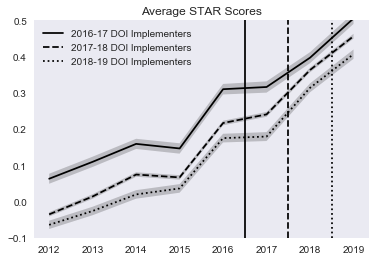

In [89]:
outcome = 'score_std'
# Create cycler object. Use any styling from above you please
df_treat2016 = create_group_df(data[data.doi_year == 2016], outcome = outcome)
df_treat2017 = create_group_df(data[data.doi_year == 2017], outcome = outcome)
df_treat2018 = create_group_df(data[data.doi_year == 2018], outcome = outcome)

monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']))

fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)

ax.plot(list(df_treat2016.index), df_treat2016['outcome']['outcome_mean'], label = '2016-17 DOI Implementers')
ax.plot(list(df_treat2017.index), df_treat2017['outcome']['outcome_mean'],label = '2017-18 DOI Implementers')
ax.plot(list(df_treat2018.index), df_treat2018['outcome']['outcome_mean'], label = '2018-19 DOI Implementers')

ax.legend()


ax.fill_between(list(df_treat2016.index), df_treat2016.lb, df_treat2016.ub, alpha = .2)
ax.fill_between(list(df_treat2017.index), df_treat2017.lb, df_treat2017.ub, alpha = .2)
ax.fill_between(list(df_treat2018.index), df_treat2018.lb, df_treat2018.ub, alpha = .2)

ax.axvline(x = 2016.5, linestyle = '-', color = 'black')
ax.axvline(x = 2017.5, linestyle = '--', color = 'black')
ax.axvline(x = 2018.5, linestyle = ':', color = 'black')

ax.set_title('Average STAR Scores')
ax.grid(False)

ax.set_ylim(-.1, .5)

fig.savefig(table_path + 'trends_by_adoption_' + 'score_std' + '.png', bbox_inches="tight")

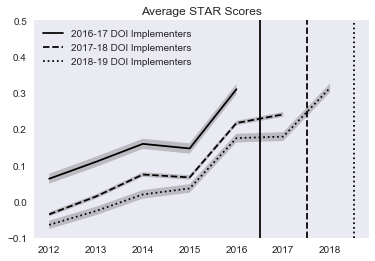

In [90]:
outcome = 'score_std'
# Create cycler object. Use any styling from above you please
df_treat2016 = create_group_df(data[data.doi_year == 2016], outcome = outcome)
df_treat2017 = create_group_df(data[data.doi_year == 2017], outcome = outcome)
df_treat2018 = create_group_df(data[data.doi_year == 2018], outcome = outcome)

monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']))

fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)

ax.plot(list(df_treat2016[df_treat2016.index <= 2016].index), df_treat2016[df_treat2016.index <= 2016]['outcome']['outcome_mean'], label = '2016-17 DOI Implementers')
ax.plot(list(df_treat2017[df_treat2016.index <= 2017].index), df_treat2017[df_treat2016.index <= 2017]['outcome']['outcome_mean'],label = '2017-18 DOI Implementers')
ax.plot(list(df_treat2018[df_treat2016.index <= 2018].index), df_treat2018[df_treat2016.index <= 2018]['outcome']['outcome_mean'], label = '2018-19 DOI Implementers')

ax.legend()


ax.fill_between(list(df_treat2016[df_treat2016.index <= 2016].index), df_treat2016[df_treat2016.index <= 2016].lb, df_treat2016[df_treat2016.index <= 2016].ub, alpha = .2)
ax.fill_between(list(df_treat2017[df_treat2017.index <= 2017].index), df_treat2017[df_treat2016.index <= 2017].lb, df_treat2017[df_treat2016.index <= 2017].ub, alpha = .2)
ax.fill_between(list(df_treat2018[df_treat2018.index <= 2018].index), df_treat2018[df_treat2016.index <= 2018].lb, df_treat2018[df_treat2016.index <= 2018].ub, alpha = .2)

ax.axvline(x = 2016.5, linestyle = '-', color = 'black')
ax.axvline(x = 2017.5, linestyle = '--', color = 'black')
ax.axvline(x = 2018.5, linestyle = ':', color = 'black')

ax.set_title('Average STAR Scores')
ax.grid(False)

ax.set_ylim(-.1, .5)

fig.savefig(table_path + 'pre_trends_by_adoption_' + 'score_std' + '.png', bbox_inches="tight")


### One possible exemption in parallel trends comes between 2014-15 for the 2018-19 implementers. While other groups decrease, this group of districts see an increase in trends.

#### Significant differentail trends?

In [91]:
did_df = data[(data.year == 2014) | (data.year == 2015)]
did_df['treat_placebo'] = np.where(did_df.doi_year == 2018, 1, 0)
did_df['post_placebo'] = np.where(did_df.year > 2014, 1, 0)
did_df['treat_post_placebo'] = did_df.treat_placebo * did_df.post_placebo

did_df = did_df.reset_index()
did_df['year'] = pd.to_datetime(did_df['year'], format='%Y')
#add column year to index
did_df = did_df.set_index(['year', 'campus'])
#swap indexes
did_df.index = did_df.index.swaplevel(0,1)
did_df[['district', 'doi_year','treat_placebo', 'post_placebo', 'treat_post_placebo']].sample(5)

,,district,doi_year,treat_placebo,post_placebo,treat_post_placebo
campus,year,,,,,
240903131,2014-01-01,240903,2017.0,0,0,0
222901001,2015-01-01,222901,2017.0,0,1,0
101905041,2015-01-01,101905,2016.0,0,1,0
15905044,2014-01-01,15905,NaN,0,0,0
57909125,2014-01-01,57909,2017.0,0,0,0


In [92]:
change_2016 = df_treat2016['outcome']['outcome_mean'].loc[2015] - df_treat2016['outcome']['outcome_mean'].loc[2014]
print(change_2016)
change_2017 = df_treat2017['outcome']['outcome_mean'].loc[2015] - df_treat2017['outcome']['outcome_mean'].loc[2014]
print(change_2017)
change_2018 = df_treat2018['outcome']['outcome_mean'].loc[2015] - df_treat2018['outcome']['outcome_mean'].loc[2014]
print(change_2018)

mod = PanelOLS.from_formula('score_std ~ 1 + treat_placebo + post_placebo + treat_post_placebo', did_df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

-0.012674444087076686
-0.007893723317491955
0.016580840895159966
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.0008
No. Observations:               72255   R-squared (Within):               0.0001
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.0005
Time:                        17:11:18   Log-likelihood                -9.908e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.286
Entities:                        5813   P-value                           0.0000
Avg Obs:                       12.430   Distribution:                 F(3,72251)
Min Obs:                       1.0000                                           
Max Obs:                       36.000   F-st

# Graph by subject

In [95]:
df_treat2016 = create_group_df(data[data.doi_year == 2016][data.test == outcome], outcome = outcome)
df_treat2016

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


outcome                      ub           lb
     outcome_mean outcome_se                          
year                                                  
2012  1461.498990   2.631025  1464.130015  1458.867965
2013  1473.925403   2.874847  1476.800250  1471.050556
2014  1470.683367   2.827696  1473.511062  1467.855671
2015  1452.992110   2.728140  1455.720251  1450.263970
2016  1472.229249   2.688637  1474.917886  1469.540612
2017  1477.610568   2.813014  1480.423582  1474.797553
2018  1471.594595   2.800104  1474.394698  1468.794491
2019  1477.901163   2.780405  1480.681568  1475.120757

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


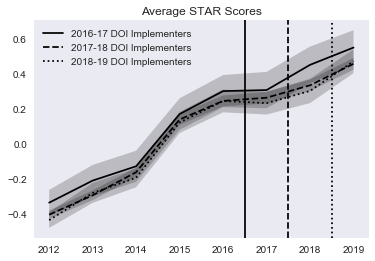

In [112]:
subjects = ['m_3rd_avescore', 'r_3rd_avescore',
            'm_4th_avescore', 'r_4th_avescore', 
            'm_5th_avescore', 'r_5th_avescore', 
            'm_6th_avescore', 'r_6th_avescore',
            'm_7th_avescore', 'r_7th_avescore',
            'm_8th_avescore', 'r_8th_avescore',
            'alg_avescore', 'bio_avescore', 'eng1_avescore']

outcome = 'score_std'
subject = 'bio_avescore'
# Create cycler object. Use any styling from above you please
df_treat2016 = create_group_df(data[data.doi_year == 2016][data.test == subject], outcome = outcome)
df_treat2017 = create_group_df(data[data.doi_year == 2017][data.test == subject], outcome = outcome)
df_treat2018 = create_group_df(data[data.doi_year == 2018][data.test == subject], outcome = outcome)

monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']))

fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)

ax.plot(list(df_treat2016.index), df_treat2016['outcome']['outcome_mean'], label = '2016-17 DOI Implementers')
ax.plot(list(df_treat2017.index), df_treat2017['outcome']['outcome_mean'],label = '2017-18 DOI Implementers')
ax.plot(list(df_treat2018.index), df_treat2018['outcome']['outcome_mean'], label = '2018-19 DOI Implementers')

ax.legend()


ax.fill_between(list(df_treat2016.index), df_treat2016.lb, df_treat2016.ub, alpha = .2)
ax.fill_between(list(df_treat2017.index), df_treat2017.lb, df_treat2017.ub, alpha = .2)
ax.fill_between(list(df_treat2018.index), df_treat2018.lb, df_treat2018.ub, alpha = .2)

ax.axvline(x = 2016.5, linestyle = '-', color = 'black')
ax.axvline(x = 2017.5, linestyle = '--', color = 'black')
ax.axvline(x = 2018.5, linestyle = ':', color = 'black')

ax.set_title('Average STAR Scores')
ax.grid(False)


fig.savefig(table_path + 'trends_by_adoption_' + 'score_std' + '.png', bbox_inches="tight")

# Demographic Trends

In [113]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2018

,year,students_hisp
0,2012,0.444129
1,2013,0.449500
2,2014,0.454304
3,2015,0.463432
4,2016,0.470314
5,2017,0.473439
6,2018,0.477036
7,2019,0.477508


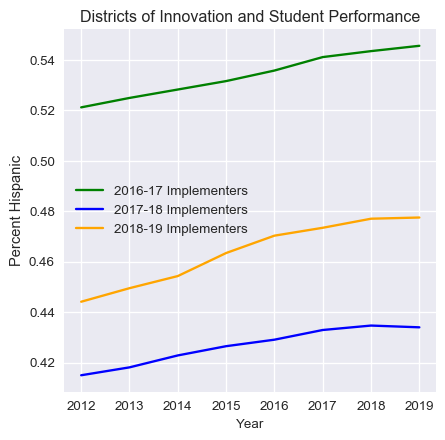

In [114]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
#plt.plot(df_control.year, df_control.students_hisp, color = 'red', label = 'TPS')
plt.plot(df_treat2016.year, df_treat2016.students_hisp, color = 'green', label = '2016-17 Implementers')
plt.plot(df_treat2017.year, df_treat2017.students_hisp, color = 'blue', label = '2017-18 Implementers')
plt.plot(df_treat2018.year, df_treat2018.students_hisp, color = 'orange', label = '2018-19 Implementers')

plt.legend()



plt.ylabel('Percent Hispanic')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()

## Number of Students

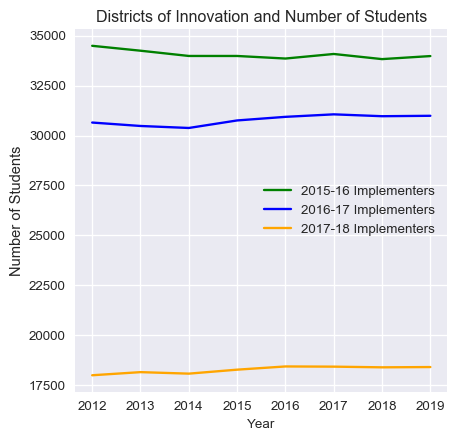

In [115]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['students_num_d'].mean()).reset_index()
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['students_num_d'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['students_num_d'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['students_num_d'].mean()).reset_index()
df_treat2018

plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_treat2016.year, df_treat2016.students_num_d, color = 'green', label = '2015-16 Implementers')
plt.plot(df_treat2017.year, df_treat2017.students_num_d, color = 'blue', label = '2016-17 Implementers')
plt.plot(df_treat2018.year, df_treat2018.students_num_d, color = 'orange', label = '2017-18 Implementers')

plt.legend()



plt.ylabel('Number of Students')
plt.title('Districts of Innovation and Number of Students')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()

In [116]:
#  Who are 2016-17 implementers
data[(data.doi_year == 2016) & (data.year == 2018)][['distname', 'students_num']]

,distname,students_num
136799,PALESTINE ISD,966
136800,PALESTINE ISD,966
136801,PALESTINE ISD,966
136802,PALESTINE ISD,966
136803,PALESTINE ISD,966
136815,SLOCUM ISD,114
136816,SLOCUM ISD,114
136817,SLOCUM ISD,114
136818,SLOCUM ISD,114
136819,SLOCUM ISD,114


# Inputs

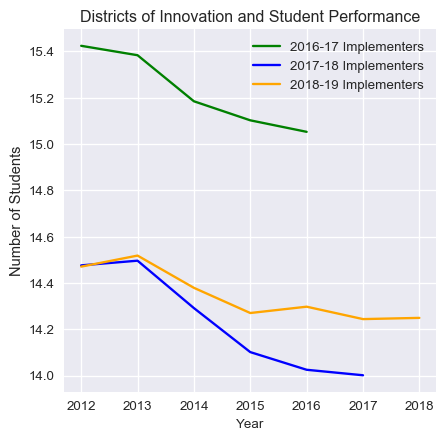

In [117]:
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['stu_teach_ratio'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['stu_teach_ratio'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['stu_teach_ratio'].mean()).reset_index()

plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_treat2016[df_treat2016.year <= 2016].year, df_treat2016[df_treat2016.year <= 2016].stu_teach_ratio, color = 'green', label = '2016-17 Implementers')
plt.plot(df_treat2017[df_treat2017.year <= 2017].year, df_treat2017[df_treat2017.year <= 2017].stu_teach_ratio, color = 'blue', label = '2017-18 Implementers')
plt.plot(df_treat2018[df_treat2018.year <= 2018].year, df_treat2018[df_treat2018.year <= 2018].stu_teach_ratio, color = 'orange', label = '2018-19 Implementers')

plt.legend()



plt.ylabel('Number of Students')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()

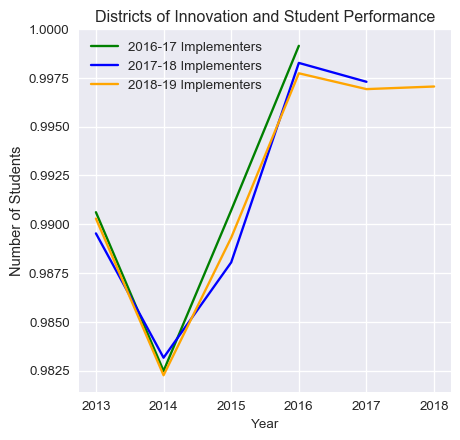

In [118]:
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['certification'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['certification'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['certification'].mean()).reset_index()

plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_treat2016[df_treat2016.year <= 2016].year, df_treat2016[df_treat2016.year <= 2016].certification, color = 'green', label = '2016-17 Implementers')
plt.plot(df_treat2017[df_treat2017.year <= 2017].year, df_treat2017[df_treat2017.year <= 2017].certification, color = 'blue', label = '2017-18 Implementers')
plt.plot(df_treat2018[df_treat2018.year <= 2018].year, df_treat2018[df_treat2018.year <= 2018].certification, color = 'orange', label = '2018-19 Implementers')

plt.legend()



plt.ylabel('Number of Students')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()